# Photon Count for Exozodiacal Dust Proposal

## NIRISS AMI Model

In [66]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

import jax
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import zodiax as zdx

jax.config.update("jax_enable_x64", True)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

In [67]:
from lib import get_files, summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    "/Users/mcha5804/JWST/COM1093/stage2/",
    "cal",
    EXP_TYPE="NIS_AMI",
    PATTTYPE="NONE",
    # FILTER="F480M",
    OBSERVTN=["013", "016", "019"],
    **kwargs,
)

stars = ["AB-DOR", "HD-37093", "HD-36805"]

files = []
for star in stars:
    fs = file_fn(TARGPROP=star)
    # print(f"\n{len(fs)}")
    # summarise_files(fs, ["ACT_ID"])
    files += fs

# # files = files[-1:]

# print(f"\n{len(files)}")
# summarise_files(files, ["ACT_ID", "NGROUPS", "NINTS", "DURATION"])

In [3]:
import dLuxWebbpsf as dlW
import matplotlib.pyplot as plt
import zodiax as zdx
import jax.numpy as np


**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [4]:
from jax import lax


def FIM(pytree, parameters, loglike_fn, *loglike_args, shape_dict={}, **loglike_kwargs):
    # Build X vec
    pytree = zdx.tree.set_array(pytree, parameters)
    shapes, lengths = zdx.bayes._shapes_and_lengths(pytree, parameters, shape_dict)
    X = np.zeros(zdx.bayes._lengths_to_N(lengths))

    # Build function to calculate FIM and calculate
    @jax.hessian
    def calc_fim(X):
        parametric_pytree = _perturb(X, pytree, parameters, shapes, lengths)
        return loglike_fn(parametric_pytree, *loglike_args, **loglike_kwargs)

    return calc_fim(X)


def _perturb(X, pytree, parameters, shapes, lengths):
    n, xs = 0, []
    if isinstance(parameters, str):
        parameters = [parameters]
    indexes = range(len(parameters))

    for i, param, shape, length in zip(indexes, parameters, shapes, lengths):
        if length == 1:
            xs.append(X[i + n])
        else:
            xs.append(lax.dynamic_slice(X, (i + n,), (length,)).reshape(shape))
            n += length - 1

    return pytree.add(parameters, xs)

In [5]:

import optax


# TODO: Add an optional 'norm_fn' that normalises the model as desired
# Maybe a process_grads fn too for fixing params?
def fit_image(
    tel,
    file,
    loss_fn,
    support,
    epochs,
    params,
    optimisers,
    starts,
    loss_scale=1e-4,
    verbose=True,
    print_grads=False,
):
    im = np.array(file[1].data).astype(float)
    err = np.array(file[2].data).astype(float)

    model = initialise_for_data(tel, file)
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)

    loss, grads = loss_fn(model, im, err, support)
    if print_grads:
        for param in params:
            print(f"{param}: {grads.get(param)}")
    losses, models_out = [], [model]

    if verbose:
        looper = tqdm(range(epochs), desc="Loss %.2f" % (loss * loss_scale))
    else:
        looper = range(epochs)

    for i in looper:
        # calculate the loss and gradient
        new_loss, grads = loss_fn(model, im, err, support)
        if new_loss > loss:
            print(
                f"Loss increased from {loss * loss_scale} to {new_loss * loss_scale} "
                f"on {i} th epoch"
            )
        loss = new_loss
        if np.isnan(loss):
            raise ValueError(f"Loss is NaN on {i} th epoch")

        for param, start in zip(params, starts):
            if i < start:
                grads = grads.multiply(param, 0.0)

        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        # TODO: Make this into a "norm fn" that allows users to specify
        # Re-normalise the source (weights and phases)
        # source = model.source
        # norm_weights = source.weights / source.weights.sum()
        # norm_phases = source.phases - source.phases[0]
        # norm_ampls = source.amplitudes / source.amplitudes[0]
        # norm_source = source.set(
        #     ["weights", "phases", "amplitudes"], [norm_weights, norm_phases, norm_ampls]
        # )
        # # norm_source = model.source.normalise()
        # model = model.set("source", norm_source)

        # save results
        models_out.append(model)
        losses.append(loss)

        if verbose:
            looper.set_description("Loss %.2f" % (loss * loss_scale))

    return losses, models_out

In [6]:
def planck(wav, T):
    h = 6.626e-34
    c = 3.0e8
    k = 1.38e-23
    a = 2.0 * h * c**2
    b = h * c / (wav * k * T)
    intensity = a / ((wav**5) * (np.exp(b) - 1.0))
    return intensity

Teffs = {
    'AB-DOR': 5280,
    'HD-37093': 4410,
    'HD-36805': 5040
}

In [7]:
import os

from lib import (
    get_webb_osys_fits,
    initialise_for_data,
    UVSource,
    get_AMI_splodge_mask,
    Null,
    loglike_fn,
    like_fn,
    Interpolator,
)

from lib import (
    compare,
    show_splodges,
    show_likelihoods,
    pairwise_vectors,
    plot_vis,
    get_nan_support,
)
from zodiax.experimental import serialise, deserialise
from nrm_analysis.misctools import mask_definitions


import zodiax as zdx
import dLuxWebbpsf as dlw
import numpy as onp

for file in tqdm(files):

    # Check for already fit
    head = file[0].header
    name = "{}_{}_{}_{}".format(head["TARGPROP"], head["FILTER"], head["OBSERVTN"], head["ACT_ID"])
    print(f"Fitting: {name}")

    tdays = file[0].header["EXPEND"] - file[0].header["EXPSTART"]
    print(f"Total Exposure Time: {tdays * 24 * 60 * 60:.2f} sec")

    # if name + '.zdx' in os.listdir('files/models/'):
    #     print(f"Already fit {name}, skipping\n")
    #     continue

    inst, psf_fits = get_webb_osys_fits(file)

    # Get modelling wavelengths
    wls = np.array([psf_fits[0].header[f"WAVE{i}"] for i in range(9)])
    source_wgts = planck(wls, Teffs[head["TARGPROP"]])

    # Create unitary weights so we can get the filter weights
    poppy_source = {'wavelengths': onp.array(wls), 'weights': onp.ones_like(wls)}
    psf_fits = inst.calc_psf(source=poppy_source)
    filt = np.array([psf_fits[0].header[f"WGHT{i}"] for i in range(9)])

    # Get spectra
    spec = filt * source_wgts

    # Get the dLux object
    tel = dlw.NIRISS(
        filter=inst.filter,
        aperture=inst.aperturename,
        detector=inst.detector,
        pupil_mask=inst.pupil_mask,
        radial_orders=[0,1,2],
        AMI=True,
    )
    tel = tel.multiply("basis", 1e-9) # Normalise to nm

    # Update with the latest WFS data
    planes = inst.optsys.planes
    tel = tel.set("pupil.opd", np.array(planes[0].opd))
    tel = tel.set("aberrations.opd", np.array(planes[2].opd))

    # Make the AMI mask interpolatable
    tf = dl.CoordTransform((0.0, 0.0), 0.0, (1.0, 1.0), (0.0, 0.0))
    pupil_mask_layer = tel.pupil_mask
    tel = tel.set('pupil_mask', Interpolator(pupil_mask_layer, tf))

    # Add a 'background' detector layer to calibrate that
    new_det = tel.detector.insert_layer(('bg', dl.AddConstant(0.)), 5)
    new_det = new_det.set('bg.value', np.array(0.0))
    tel = tel.set('detector', new_det)

    # Remove Charge Diffusion and initialise for data
    tel = tel.set("ChargeDiffusion", Null())

    # Create a 'clean' telescope 
    # tel = tel.set(['aberrations', 'SIAF', 'IPC'], Null())
    tel = tel.set(['aberrations', 'SIAF'], Null())
    tel = initialise_for_data(tel, file)

    # Generate Mask
    mask_path = f"files/masks/{head['FILTER']}.npy"
    if os.path.exists(mask_path):
        print("Using cached mask")
        masks = np.load(mask_path)
    else:
        print("Generating mask")
        masks = get_AMI_splodge_mask(tel, wls, verbose=False)
        np.save(mask_path, masks)

    # Create source
    source = UVSource(wls, masks, flux=tel.flux, position=tel.position, weights=spec)
    model = tel.set("source", source)

    # Get support
    support, support_mask = get_nan_support(file, n_mask=25, order=1)

    # Define loss function
    params = [
        "position",
        "flux",
        'bg.value',

        "translation",
        "rotation",
        "compression",
        "shear",
        "coefficients",
        "amplitudes",
        "phases"
    ]

    @zdx.filter_jit
    @zdx.filter_value_and_grad(params)
    def loss_fn(model, data, err, support):
        return -loglike_fn(model, data, err, support).sum()

    # Evaluate
    print("Compiling")
    im = np.array(file[1].data).astype(float)
    err = np.array(file[2].data).astype(float)
    loss, grads = loss_fn(model, im, err, support)

    # for param in params:
    #     print(param)
    #     print(f"{grads.get(param)}")
    #     print(f"{grads.get(param) / model.get(param)}")
    #     print()

    # Check for nans in loss and grads
    # [print(v) for v in grads.get(params) + [loss]]
    isnan = [np.isnan(v).any() for v in grads.get(params) + [loss]]
    if any(isnan):
        print("NaNs in loss or grads. skipping")

        continue

    # Optimise
    optimisers = [
        optax.sgd(2e-10), # pos
        optax.sgd(2e6),   # flux
        optax.sgd(2e-4),   # bg
        
        optax.sgd(1e-3),   # translation
        optax.sgd(1e-10),   # rotation
        optax.sgd(2e-10),   # compression
        optax.sgd(1e-10),   # shear

        optax.sgd(1e-2),  # coeff
        optax.sgd(10e-8),  # ampl
        optax.sgd(1e-7),  # phase
    ]

    # starts = [
    #     0,   # pos
    #     5,   # flux
    #     10,  # translation
    #     10,  # rotation
    #     10,  # compression
    #     10,  # shear
    #     30,  # coeff
    #     50,  # ampl
    #     50,  # phase
    # ]

    # TODO: Clip step sizes by some pre-defined max value? Ie 0.5 pixels for pos, 1e5 for flux etc
    k = 3
    starts = [
        0,   # pos
        k,   # flux
        k,   # bg
        k,  # translation
        k,  # rotation
        k,  # compression
        k,  # shear
        k,  # coeff
        k,  # ampl
        k,  # phase
    ]

    print(f"Fitting...")
    try:
        # Optimisation
        losses, models_out = fit_image(
            model, file, loss_fn, support, 50, params, optimisers, starts
        )

        # Fisher information
        marg_params = ["position", "flux", "amplitudes", "phases"]

        print("Calculating Fisher Information...")
        llike_fn = lambda model: loglike_fn(model, im, err, support).sum()
        fim = FIM(models_out[-1], marg_params, llike_fn, shape_dict={})
    
    except ValueError as e:
        print("Value Error found, Skipping")
        continue

    # Get the params from each model
    params_out = {}
    for param in params:
        params_out[param] = [model.get(param) for model in models_out]

    serialise(f"files/models/{name}.zdx", models_out[-1])
    serialise(f"files/params/{name}.zdx", params_out)
    np.save(f"files/losses/{name}.npy", losses)
    np.save(f"files/fims/{name}", fim)

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting: AB-DOR_F430M_013_03
Total Exposure Time: 30.93 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 276.27:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: AB-DOR_F480M_013_05
Total Exposure Time: 30.63 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 407.42:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: AB-DOR_F380M_013_04
Total Exposure Time: 36.21 sec
Loading WFS data
Generating mask
Compiling
Fitting...


Loss 291.56:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: AB-DOR_F480M_013_02
Total Exposure Time: 31.23 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 277.45:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-37093_F430M_016_03
Total Exposure Time: 58.84 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 296.26:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-37093_F380M_016_04
Total Exposure Time: 44.51 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 287.81:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-37093_F480M_016_02
Total Exposure Time: 59.82 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 277.55:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-36805_F430M_019_03
Total Exposure Time: 43.30 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 298.26:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-36805_F380M_019_04
Total Exposure Time: 36.81 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 224.96:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...
Fitting: HD-36805_F480M_019_02
Total Exposure Time: 49.04 sec
Loading WFS data
Using cached mask
Compiling
Fitting...


Loss 378.71:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating Fisher Information...


In [9]:
tel

NIRISS(
  optics=AngularOpticalSystem(
    wf_npixels=1024,
    diameter=6.603464,
    layers={
      'pupil':
      JWSTAberratedPrimary(
        basis=f64[7,6,1024,1024],
        coefficients=f64[7,6],
        as_phase=False,
        opd=f64[1024,1024],
        phase=None,
        transmission=f64[1024,1024],
        normalise=True,
        pixelscale=None
      ),
      'InvertY':
      Flip(axes=0),
      'aberrations':
      Null(),
      'pupil_mask':
      Interpolator(
        transform=CoordTransform(
          translation=f64[2],
          rotation=f64[],
          compression=f64[2],
          shear=f64[2]
        ),
        order=1,
        layer=Optic(
          opd=None,
          phase=None,
          transmission=f64[1024,1024],
          normalise=False
        )
      )
    },
    psf_npixels=80,
    oversample=4,
    psf_pixel_scale=0.06552408500000001
  ),
  source=PointSource(
    spectrum=Spectrum(wavelengths=f64[9], weights=f64[9]),
    position=f64[2],
    flux=

In [46]:
from zodiax.experimental import serialise, deserialise
import zodiax as zdx
import jax.numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams['image.origin'] = 'lower'

fin_model = deserialise("files/models/AB-DOR_F480M_013_02.zdx")

print(fin_model)

/Users/mcha5804/miniconda3/envs/dLux/lib/python3.10/site-packages/zodiax/experimental/serialisation.py:514: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  obj = jnp.zeros(structure['shape'], dtype=dtype)


NIRISS(
  optics=AngularOpticalSystem(
    wf_npixels=1024,
    diameter=6.603464,
    layers={
      'pupil':
      JWSTAberratedPrimary(
        basis=f32[7,6,1024,1024],
        coefficients=f32[7,6],
        as_phase=False,
        opd=f32[1024,1024],
        phase=None,
        transmission=f32[1024,1024],
        normalise=True,
        pixelscale=None
      ),
      'InvertY':
      Flip(axes=0),
      'aberrations':
      Null(),
      'pupil_mask':
      Interpolator(
        transform=CoordTransform(
          translation=f32[2],
          rotation=f32[],
          compression=f32[2],
          shear=f32[2]
        ),
        order=1,
        layer=Optic(
          opd=None,
          phase=None,
          transmission=f32[1024,1024],
          normalise=False
        )
      )
    },
    psf_npixels=80,
    oversample=4,
    psf_pixel_scale=0.06552408500000001
  ),
  source=UVSource(
    wavelengths=f32[9],
    weights=f32[9],
    position=f32[2],
    flux=f32[],
    mask=f3

In [14]:
# Marginal parameters
# I think we want to marginalise over position, flux, aberrations, vis amplitudes and vis phases - Louis
params = [
    "flux",
    "position",
    "amplitudes",
    "phases",
    "pupil.coefficients",
]

# Define our likelihood function and bind it to our covariance function
# We use poissonian here because we are assuming photon noise is our dominant noise source
calc_cov = lambda model, parameters: zdx.self_covariance_matrix(model, parameters, zdx.poiss_loglike, shape_dict={})
cov_fn = zdx.filter_jit(calc_cov)

# Compile
init_cov = cov_fn(fin_model, params)

TypeError: reshape total size must be unchanged, got new_sizes (7, 6) for shape (6,).

In [ ]:
fluxes = np.logspace(8, 11, 3)
covs, stds = [], []

for idx, flux in enumerate(tqdm(fluxes)):
    model = fin_model.set("flux", flux)
    cov = cov_fn(model, params)
    covs.append(cov)
    stds.append(np.sqrt(np.diag(np.abs(cov))))

covs = np.array(covs)
stds = np.array(stds)

  0%|          | 0/5 [00:00<?, ?it/s]

## Plotting

In [112]:
def plot_fim(start, stop, param: str = None):
    signal = fin_model.get(param)
    SNR = 7/np.sqrt(2) * np.sqrt(fluxes)

    fig, ax = plt.subplots()
    for i in range(start, stop):
        label = param if i == start else None
        label2 = "Analytic" if i == start else None
        ax.loglog(fluxes, stds[:, i], marker='o', label=label)
        if param == "amplitudes" or param == "phases":
            if param == "phases":
            ax.loglog(fluxes, signal[i] / SNR, color='k', ls='--', label=label2)

    ax.set(title=param, xlabel="Flux [phot]", ylabel=f"$\sigma$ of {param}")
    if param == "amplitudes" or param == "phases":
        ax.axhline(1e-3, color='r', ls='--', label="Detection Threshold")
    ax.grid(alpha=0.3, which='both')
    ax.legend()
    plt.show()

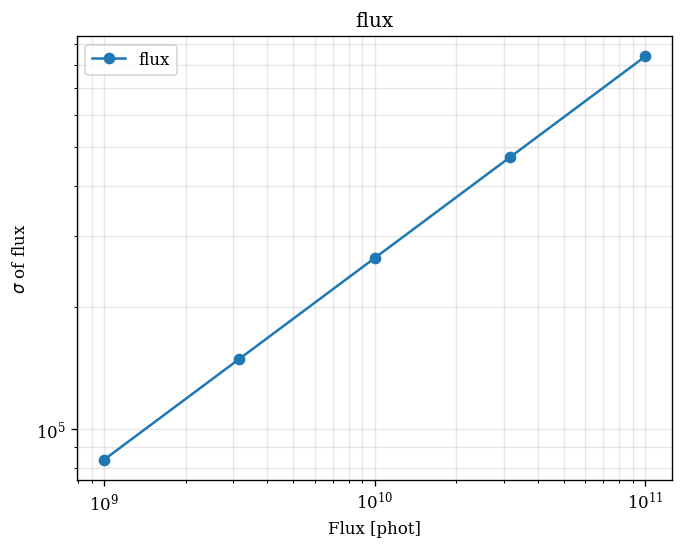

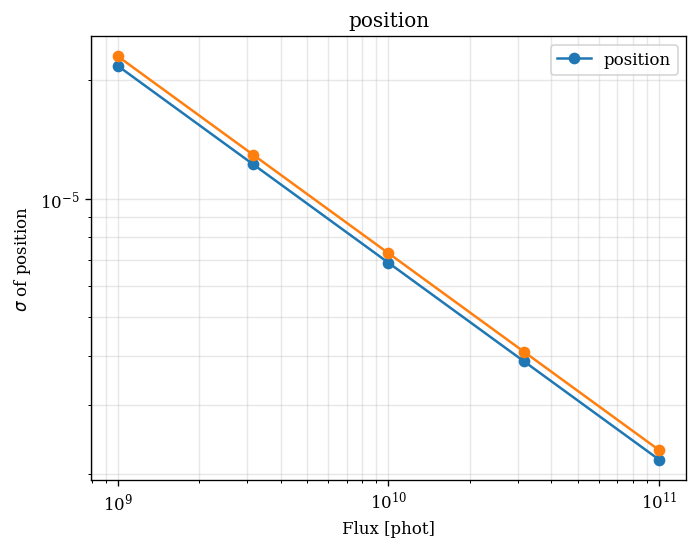

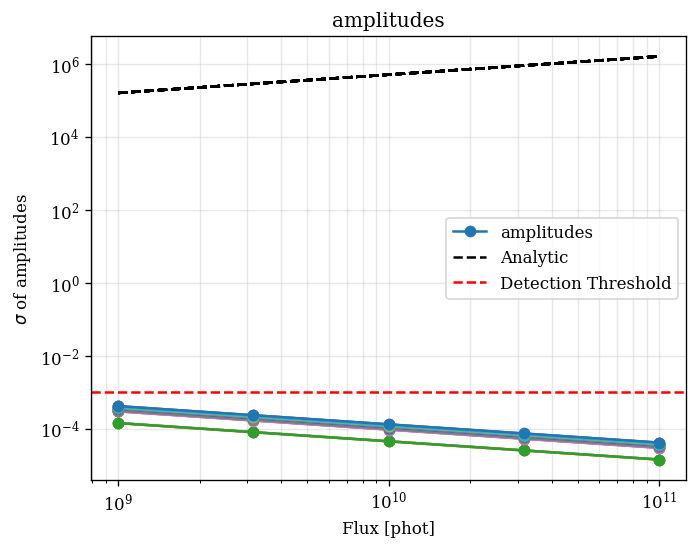

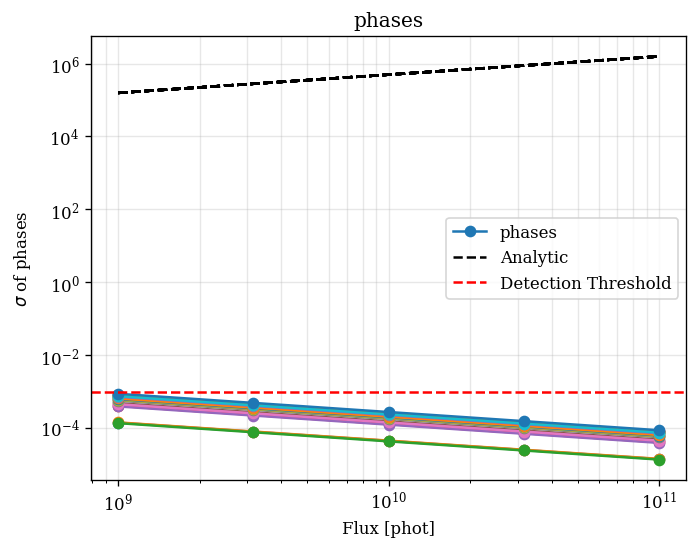

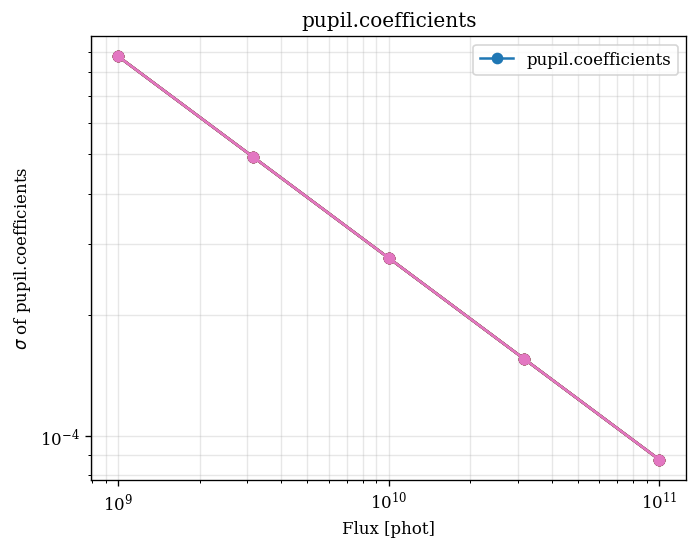

In [113]:
counter = 0
for param in params:
    shape = fin_model.get(param).shape
    if shape == ():
        shape = (1,)
    plot_fim(counter, counter+shape[0], param)

    counter += shape[0]

# Saturation

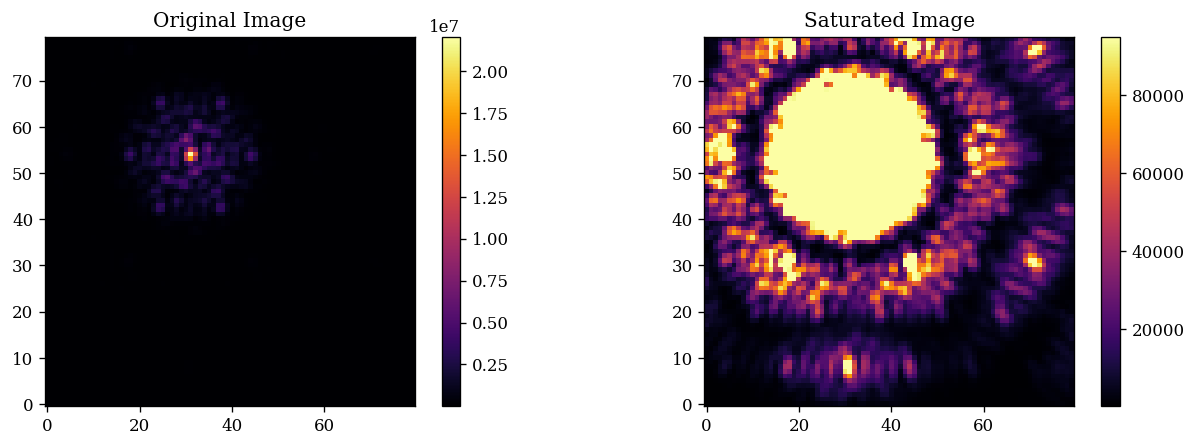

In [111]:
import matplotlib.pyplot as plt

FWD = 95000
flux = 1e10
img = fin_model.set("flux", flux).model()
saturated = np.where(img > FWD, FWD, img)

fig, axs = plt.subplots(1, 2, figsize=(13, 4))
im0 = axs[0].imshow(img)
axs[0].set_title("Original Image")
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(saturated)
axs[1].set_title("Saturated Image")
fig.colorbar(im1, ax=axs[1])
plt.show()

In [91]:
def flux_lost(img, FWD):
    saturated = np.where(img > FWD, FWD, img)
    lost = img - saturated 
    fraction_lost = lost.sum() / img.sum()
    return fraction_lost

In [105]:
lost = []
lost_fluxes = np.logspace(7, 12, 15)
FWD = 95000

for flux in tqdm(lost_fluxes):
    model = fin_model.set("flux", flux)
    img = model.model()
    lost.append(flux_lost(img, FWD))

lost = np.array(lost)

  0%|          | 0/15 [00:00<?, ?it/s]

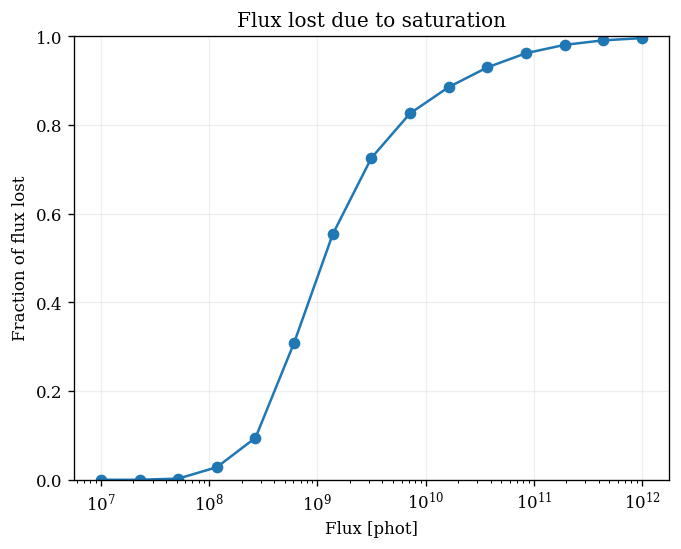

In [106]:
plt.plot(lost_fluxes, lost, marker='o')
plt.xscale('log')
plt.ylim(0, 1)
plt.xlabel('Flux [phot]')
plt.ylabel('Fraction of flux lost')
plt.title('Flux lost due to saturation')
plt.grid(alpha=0.2)
plt.show()


# ETC Output

In [117]:
from astropy.io import fits

filt = "F480M"
path = f"data/ETC/{filt}/image/"

file_det = "image_detector.fits"
file_ngroups = "image_ngroups_map.fits"
file_sat = "image_saturation.fits"
file_snr = "image_snr.fits"

In [208]:
ngroups = fits.open(path + file_ngroups)[0]
det = fits.open(path + file_det)[0]
psf = np.array(det.data)
total_flux = np.nansum(psf)

n = 10
losts = []

for i in range(1, n+1):
    mask = np.where(ngroups.data <= i, 1, 0)
    lost = psf * mask
    lost_flux = np.nansum(lost)
    losts.append(lost_flux / total_flux)

    # fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # ax[0].imshow(psf)
    # ax[1].imshow(mask)
    # plt.show()

    # plt.imshow(psf * mask)
    # plt.title(f"ngroups = {i}")
    # plt.savefig(f"figures/plot_{i}.png", dpi=300, bbox_inches='tight')
    # plt.close()

losts = np.array(losts)

[0.         0.02580327 0.0643541  0.15815593 0.21926536 0.29029649
 0.35952379 0.41555242 0.46860785 0.51339263]


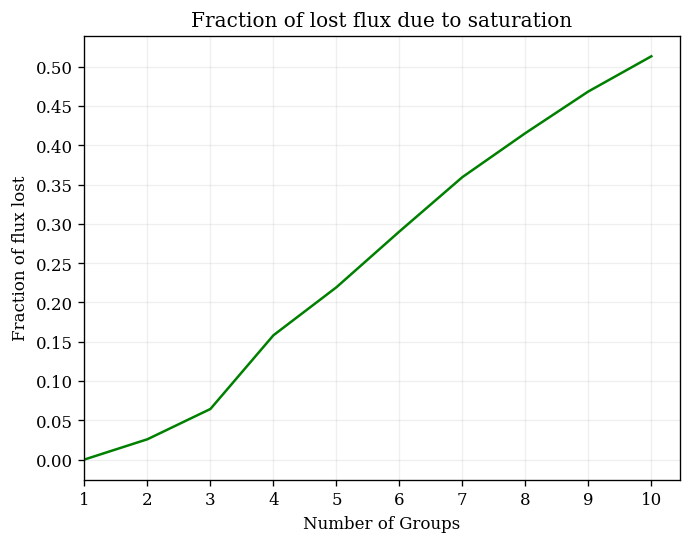

In [210]:
fig, ax = plt.subplots()
ax.plot(range(1, n+1), losts, color='green')
ax.set(
    title="Fraction of lost flux due to saturation",
    xlabel="Number of Groups",
    ylabel="Fraction of flux lost",
    # ylim=(0, 1),
    xlim=(1, None),
    xticks=range(1, n+1),
    yticks=np.linspace(0, 0.5, 11),
    )
# ax.axhline(1, ls='--', color='k')
ax.grid(alpha=0.2)

print(losts)


In [190]:
import imageio

# Get the list of files
files = sorted([f"figures/plot_{i}.png" for i in range(1, n+1)])

# Create the gif
with imageio.get_writer('animation.gif', mode='I') as writer:
    for filename in files:
        image = imageio.imread(filename)
        writer.append_data(image)

# Save the created GIF to a specific location
output_path = 'figures/ngroups.gif'
imageio.mimsave(output_path, [imageio.imread(filename) for filename in files], duration=5)

# Print a message to confirm the save location
print(f'GIF saved to: {output_path}')


/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_60027/1298490515.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/7d/c7wd3zcx3dlc6fmsmqwykh0m0000gn/T/ipykernel_60027/1298490515.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(output_path, [imageio.imread(filename) for filename in files], duration=5)


GIF saved to: figures/ngroups.gif


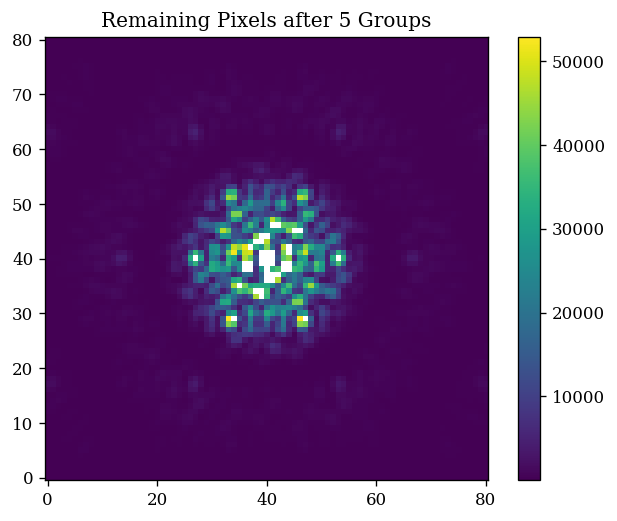

In [201]:
mask = np.where(ngroups.data <= 5, np.nan, 1)
import matplotlib.pyplot as plt

# create a masked PSF
masked_psf = psf * mask

# plot the masked PSF
plt.imshow(masked_psf, cmap='viridis')
plt.colorbar()
plt.title("Remaining Pixels after 5 Groups")
plt.show()


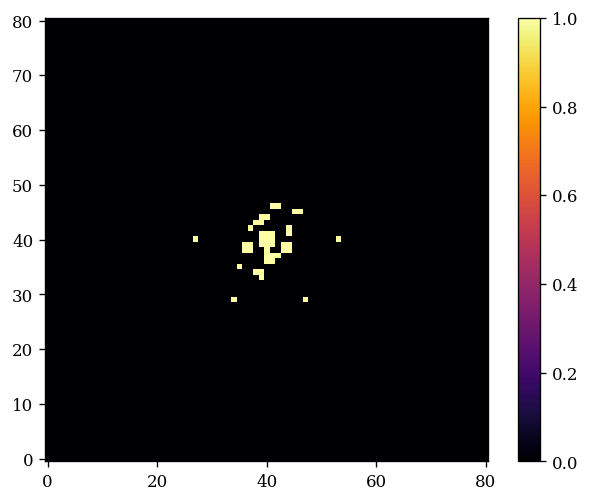

In [195]:
plt.imshow(mask)
plt.colorbar()
plt.show()
